# Sensitivity Analysis with correlated and non-uniformly distributed inputs

Notebook developed by Saman Razavi, Cordell Blanchard, and Kasra Keshavarz

### For the Generalized VARS (G-VARS) method, please cite:

Do, N. C., & Razavi, S. (2020). Correlation effects? A major but often neglected component in sensitivity and uncertainty analysis. Water Resources Research, 56(3), e2019WR025436. https://doi.org/10.1029/2019WR025436

### For HBV-SASK, please cite:

Razavi, S., Sheikholeslami, R., Gupta, H. V., & Haghnegahdar, A. (2019). VARS-TOOL: A toolbox for comprehensive, efficient, and robust sensitivity and uncertainty analysis. Environmental modelling & software, 112, 95-107. https://www.sciencedirect.com/science/article/pii/S1364815218304766

## Exercise 3: Sensitivity Analysis of HBV-SASK with correlated parameters
### Objective:

This notebook runs a sensitivity analysis of the HBV-SASK model when the model parameters may be correlated and/or non-uniformly distributed, through the *Generalized VARS (G-VARS)* method.

First import the needed librares, including `GVARS` for G-VARS and the `Model` class for creating a wrapper around the desired model so that it can be inputted into VARS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats

from varstool import GVARS, Model
import hbv

### Introduce the model

Define the function of interest in sensitivity analysis. Here, the following function runs the HBV-SASK model and returns a single output such as a flux (e.g., *streamflow*) or state variable (e.g., *soil moisture*) at a certain point in time, or a signature response such as *the highest simulated peak* or an estimate of *the 100-year flood*.

In [2]:
def custom_HBV_SASK_3(x):
    # preparing the inputs 
    
    # in case you need to fix one or more parameters, remove them from your VARS experiment 
    # and supply the fixed parameter values below.    
#     xtemp=pd.Series({'PM'   : 1  })
#     x=x.append(xtemp)
    
    param = x.to_dict()
    
    # running the HBV-SASK Model
    basin = 'Oldman Basin'  # choose the basin of interest, either 'Oldman Basin' or 'Banff Basin'
    flux, state, forcing = hbv.HBV_SASK(basin, param)

    # choose the model output, three options below: 
    
    # (1) for direct model response at a given time step, use the following
    start_day = end_day = '2005-10-05' # choose the date of interest
    out = flux['Q_cms'][start_day:end_day]
    
    # (2) for the highest peak based on simulated streamflow time series, use the following
#     out = flux['Q_cms'].max()
        
    # (3) for an estimate of annual flood peak with a certain return period, use the following
#     return_period = 100      # in years
#     pr_of_exceedance = 1 - 1/return_period  
#     start_day = '1980-01-01' # choose the start date for the period of interest
#     end_day   = '2008-12-31' # choose the end date for the period of interest
    
#     daily_time_series = flux['Q_cms'][start_day:end_day]
    
#     annual_max_data = daily_time_series.resample('A').max() # extract annual maximums for the time period
    
# #     dist_param = stats.distributions.gumbel_r.fit(annual_max_data)                         # use this line for gumbel distribution
# #     out = stats.distributions.gumbel_r.ppf(pr_of_exceedance, dist_param[0], dist_param[1]) # use this line for gumbel distribution

#     dist_param = stats.distributions.genextreme.fit(annual_max_data)                         # use this line for generalized extreme value distribution 
#     out = stats.distributions.genextreme.ppf(pr_of_exceedance, dist_param[0], dist_param[1], dist_param[2]) # use this line for generalized extreme value distribution 

    return out

Wrap the function of interest with the `Model` class.

In [3]:
HBV_model = Model(custom_HBV_SASK_3)

Let's run the wrapped function for an arbitrary input and check the model output.

In [4]:
x=pd.Series({#name  #value
             'TT'   : 0.0 ,
             'C0'   : 1.0 ,
             'ETF'  : 0.1 ,
             'LP'   : 0.3 ,
             'FC'   : 250 ,
             'beta' : 2.0 ,
             'FRAC' : 0.7 ,
             'K1'   : 0.05,
             'alpha': 1.5 ,
             'K2'   : 0.01,
             'UBAS' : 1.0 ,
             'PM'   : 1.0 ,
             })
HBV_model(x)

2005-10-05    16.315388
Name: Q_cms, dtype: float64

### Set up a GVARS experiment

Create a GVARS experiment and set its attributes. `GVARS` shares the attributes listed in Table 1 with `VARS`, while it also has some unique attributes explained after.
***

<p><center>Table 1. The attributes that GVARS inherits from VARS </center></p>

| Attribute      | Description |
| :-------------:|:----------- |
|`num_stars`     | The total number of stars centers for VARS analysis                        |
|`ivars_scales`  | The scales of interest for IVARS estimation, e.g, 0.1 and 0.5 correspond (0-0.1) and (0-0.5) <br /> note: can not have a scale larger than 0.5|
|`star_centres`  | User-generated star centers - only used when a sampler is not chosen       |
|`sampler`       | The sampling strategy: `rnd`, `lhs`, `plhs`, `sobol_seq`, or `halton_seq` for generation of star centers|
|`seed`          | The seed number for randomization of the sampling strategy specified by `sampler`, <br /> only needed if a sampler was chosen  |
|`model`         | The wrapper of your model in the `Model` class|
|`bootstrap_flag`| This is a `True`/`False` value to turn on/off bootstrapping of VARS results   |
|`bootstrap_size`| The number of sampling iterations with replacement via bootstrapping |
|`bootstrap_ci`  | The level of confidence used in bootstrap reporting         |
|`grouping_flag` | This is a `True`/`False` value to turn on/off grouping of VARS results   |
|`num_grps`      | The number of groups you want to split your model paramaters into, <br /> if left blank the optimal number of groups will be calculated by VARS|
|`report_verbose`| this is a `True`/`False` value that if `True` will display a loading bar <br /> to show the progession of the VARS analysis, else there will be no progression loading bar|

***
GVARS has three unique attributes: `parameters`, `corr_mat`, and `num_dir_samples`, as explained in the following.

`parameters` includes the name of every model parameter, the distribution it follows, and the parameters specifying that distribution. The distributions currently available and their parameters are listed in Table 2.

<p><center>Table 2. The parameter distributions currently supported in GVARS </center></p>

| Distribution type        | Distribution parameter 1 | Distribution parameter 2 | Distribution parameter 3 | Distribution identifier |
| :-----------------------:|:-----------------------: |:-----------------------: |:-----------------------: |:----------: |
|uniform                   | lower bound              | upper bound              | None                     |  `unif`     |
|triangle                  | lower bound              | upper bound              | mode                     |  `triangle` |
|normal                    | mean                     | standard deviation       | None                     |  `norm`     |
|lognormal                 | mean                     | standard deviation       | None                     |  `lognorm`  |
|exponential               | mean                     | standard deviation       | None                     |  `expo`     |
|generalized extreme value | location                 | scale                    | shape                    |  `gev`      |


`corr_mat` is the correlation matrix which includes the Pearson correlation between every pair of parameters and must be defined as a numpy array.


`num_dir_samples` is the number of samples GVARS takes along each direction for every star center. 
***
**A "good-to-know" peice for advanced users:**

In GVARS, the star-based sampling is modified to work with `num_stars` and `num_dir_samples`. This is unlike VARS where the star-based sampling works with `num_stars` and `delta_h`.

GVARS still needs `delta_h` as an attribute for estimating and reporting directional variograms (not for sampling). As a rule-of-thumb, the user may set `delta_h` to be the reciprocal of `num_dir_samples`. For example, if num_dir_samples = 10, we suggest delta_h = 0.1.

An advanced user may try other values of `delta_h` to extract more accurate results. In general, the smaller the `delta_h`, the more granular the results. But, the tradeoff with smaller values would be to have fewer pairs in the bins when estimating variograms.


In [5]:
my_parameters = { # name  dist_par1  dist_par1  dist_par1  dist_type
                 'TT'   : (  0.940  ,  0.980  ,   None   , 'unif'     ),
                 'C0'   : (  0.782  ,  0.003  ,   None   , 'norm'     ),
                 'ETF'  : (  0.126  ,  0.008  ,   None   , 'norm'     ),
                 'LP'   : (  0.670  ,  0.018  ,   None   , 'norm'     ),
                 'FC'   : (  227.53 ,  6.930  ,   None   , 'norm'     ),
                 'beta' : (  2.600  ,  3.000  ,  3.000   , 'triangle' ),
                 'FRAC' : (  0.628  ,  0.011  ,   None   , 'norm'     ),
                 'K1'   : (  0.050  ,  0.054  ,  0.050   , 'triangle' ),
                 'alpha': (  1.602  ,  0.011  ,   None   , 'norm'     ),
                 'K2'   : (  0.022  ,  0.001  ,   None   , 'norm'     ),
                 'UBAS' : (  1.000  ,  1.200  ,  1.000   , 'triangle'  ),
                 'PM'   : (  0.980  ,  1.020  ,   None   , 'unif'     ),}

my_corr_mat = np.array([[    1, 0.65,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
                        [ 0.65,    1,    0,    0,    0,    0,    0,    0,    0, 0.12,    0,    0],
                        [    0,    0,    1, 0.12,-0.18, 0.13,    0,    0,    0,-0.22,    0,    0],
                        [    0,    0, 0.12,    1, 0.54, 0.71,-0.14,    0,    0,    0,    0,    0],
                        [    0,    0,-0.18, 0.54,    1, 0.34, 0.20, 0.11,    0, 0.38,    0,    0],
                        [    0,    0, 0.13, 0.71, 0.34,    1,-0.11,    0,    0,-0.13,    0,    0],
                        [    0,    0,    0,-0.14, 0.20,-0.11,    1,    0,-0.69,-0.39,-0.19,    0],
                        [    0,    0,    0,    0, 0.11,    0,    0,    1,-0.34,    0,    0,    0],
                        [    0,    0,    0,    0,    0,    0,-0.69,-0.34,    1, 0.41, 0.40,    0],
                        [    0, 0.12,-0.22,    0, 0.38,-0.13,-0.39,    0, 0.41,    1, 0.14,    0],
                        [    0,    0,    0,    0,    0,    0,-0.19,    0,  0.4, 0.14,    1,    0],
                        [    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1]])

my_num_dir_samples = 10

my_delta_h = 0.1
# my_delta_h = 1 / my_num_dir_samples # or choose values such as 0.1

experiment_3 = GVARS(parameters     = my_parameters,
                    corr_mat        = my_corr_mat,
                    num_stars       = 20,
                    num_dir_samples = my_num_dir_samples,
                    delta_h         = my_delta_h,
                    ivars_scales    = (0.1, 0.3, 0.5),
                    sampler         = 'plhs',
                    slice_size      = 10,
                    model           = HBV_model,
                    seed            = 123456789,
                    bootstrap_flag  = False,
                    bootstrap_size  = 100,
                    bootstrap_ci    = 0.9,
                    grouping_flag   = False,
                    num_grps        = 3,
                    report_verbose  = True,
                    )

### Run STAR-GVARS

Now, run the GVARS experiment set up above.

In [ ]:
experiment_3.run_online()

building fictive matrix:   0%|          | 0/11 [00:00<?, ?it/s]

Function could not converge, fictive matrix was not computed
It is recommended to switch fictive_mat_flag parameter to False to assume that correlation matrix is equal to fictive matrix


### Check out the results

When the GVARS analysis is completed, let's check out the results of sensitivity analysis.

**IVARS: Integrated variogram Across a Range of Scales** 

IVARS indices are the primary sensitivity indices by the VARS approach. First, print all the IVARS indices for the scale ranges of interest.

In [21]:
cols = experiment_3.parameters.keys()
experiment_3.ivars[cols]

# display(experiment_3.ivars)
# display(experiment_3.pair_df)
# display(experiment_3.gamma.unstack(0))

,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
0.1,4.154788e-08,8.864018e-08,0.000325,0.000633,0.000179,0.000070,0.000046,0.000007,0.000041,0.000199,0.000005,0.000788
0.3,7.582605e-07,1.600111e-06,0.005624,0.011280,0.003455,0.001278,0.000772,0.000128,0.000679,0.003634,0.000095,0.014004
0.5,3.272980e-06,7.520961e-06,0.024665,0.044529,0.013011,0.006153,0.002990,0.000569,0.001856,0.015844,0.000490,0.059702


 Choose a scale range and plot the respective IVARS indices. Two points:
 
    POINT1: VARS-50 (h=[0-0.5]), called ***Total-Variogram Effect*** is the most comprehensive sensitivity index.
    POINT2: Plotting sensitivity results in log scale helps us better differentiate less influential parameters.

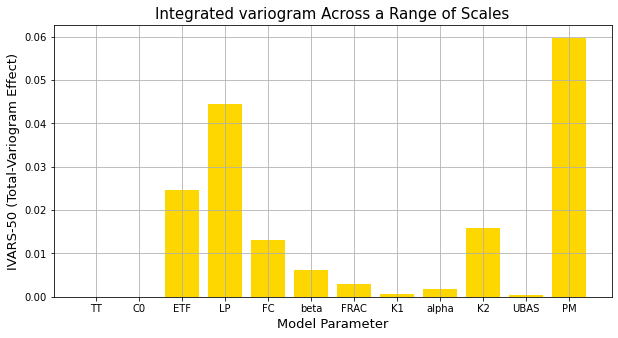

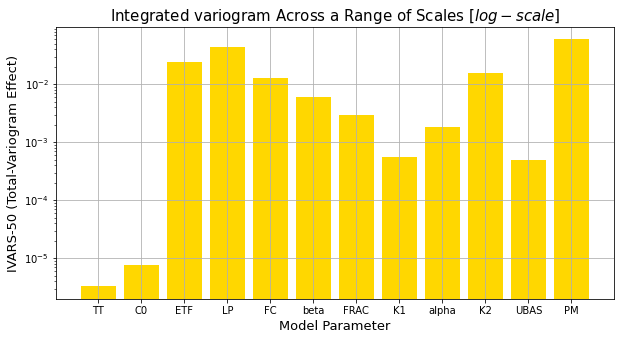

In [8]:
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_3.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**VARS-TO: Sobol Total-Order Effect** 

In addition to the IVARS indices, VARS estimates Sobol variance-based total-order effects as side products. Below, print them and plot them.

In [9]:
cols = experiment_3.parameters.keys()
experiment_3.st.to_frame().T[cols]

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
0,0.000023,0.000013,0.068295,0.068599,0.020745,0.019302,0.004373,0.0024,0.004017,0.028596,0.002935,0.711825


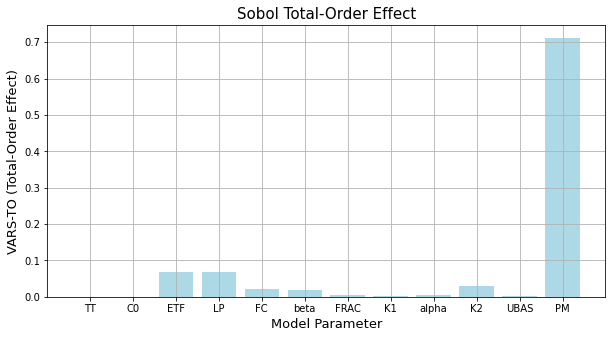

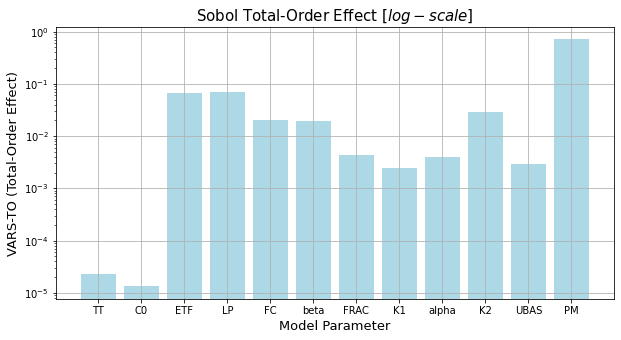

In [10]:
cols = experiment_3.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**VARS-ABE & VARS-ACE: Morris Elementary Effects** 

In addition to the IVARS and Sobol indices, VARS estimates various versions of Morris derivative-based elementary effects as side products, **mean ABsolute Elementary effect (ABE)** and **mean ACtual elementary effect (ACE)**.

    POINT: In the derivative-based approach, the user needs to choose a delta (step size) for numerical estimation of derivatives. Recommended is to go with the smallest delta available here, which is equal to delta_h, but the user could choose any integer product of delta_h as well.

 Below, print VARS-ABE & VARS-ACE and then plot them.

In [11]:
# delta_of_interest = experiment_3.maee.to_frame().unstack(level=0).index.min() # This lines chooses the smallest delta
delta_of_interest = 0.1  # This line can be used to set other values for delta

# VARS-ABE
experiment_3.maee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T

0                                                              \
param        C0       ETF        FC      FRAC        K1        K2        LP   
0.1    0.001802  0.109399  0.080761  0.041351  0.015557  0.085363  0.152541   

                                                        
param        PM        TT      UBAS     alpha     beta  
0.1    0.171647  0.001232  0.012147  0.038878  0.05045

In [12]:
# VARS-ACE
experiment_3.mee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T

0                                                              \
param        C0       ETF        FC      FRAC        K1        K2        LP   
0.1   -0.000024  0.005673  0.017062  0.001031 -0.003115 -0.002119 -0.005638   

                                                        
param        PM       TT      UBAS     alpha      beta  
0.1    0.002688  0.00003  0.000366  0.002488 -0.000011

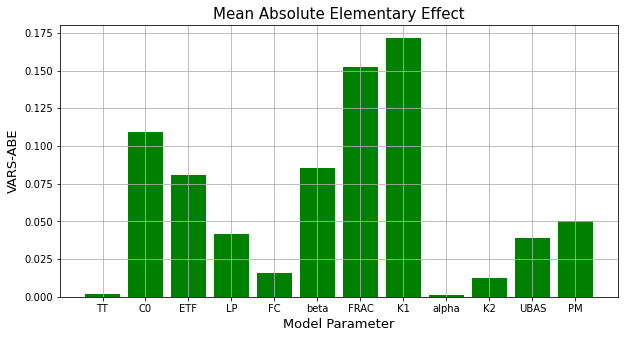

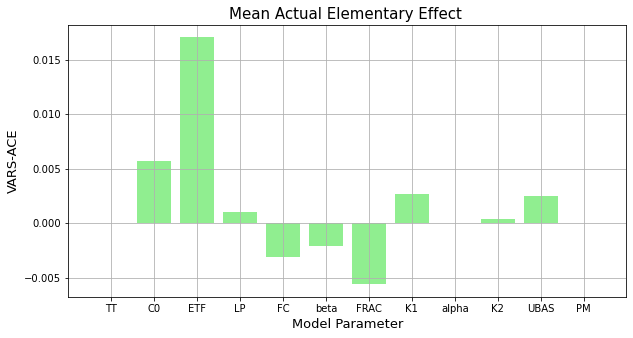

In [13]:
cols = experiment_3.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.maee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T.iloc[0], color='green')
plt.gca().set_title (r'Mean Absolute Elementary Effect', fontsize = 15)
plt.gca().set_ylabel(r'VARS-ABE', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.mee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T.iloc[0], color='lightgreen')
plt.gca().set_title (r'Mean Actual Elementary Effect ', fontsize = 15)
plt.gca().set_ylabel(r'VARS-ACE', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

**Directional Variograms - γ(h)** 

For advanced users of VARS, directional variograms may provide a wealth of information about the structure of the model response surface.

    POINT: Variograms are most meaningful when h (perturbation scale) is between zero and 0.5 of the parameter ranges, but the user can investigate the entire perturbation range (0 – 1).
    
 Below, print the directional variograms and then plot them.

In [14]:
cols = experiment_3.parameters.keys()                     
variograms = experiment_3.gamma.unstack(0)[cols].copy()
variograms

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
h,,,,,,,,,,,,
0.025,6.600850e-08,1.514825e-07,0.000439,0.000908,0.000287,0.000106,0.000082,0.000011,0.000072,0.000325,0.000006,0.001002
0.100,8.309576e-07,1.772804e-06,0.006502,0.012652,0.003570,0.001392,0.000927,0.000132,0.000822,0.003975,0.000107,0.015758
0.200,3.169937e-06,6.883382e-06,0.024025,0.047015,0.013989,0.005287,0.003324,0.000536,0.003023,0.015424,0.000409,0.060948
0.300,7.163421e-06,1.468986e-05,0.051420,0.106267,0.033983,0.012207,0.006941,0.001221,0.005885,0.033890,0.000870,0.126662
0.400,1.216664e-05,2.947406e-05,0.096485,0.186235,0.052382,0.023906,0.012470,0.002163,NaN,0.058054,0.001852,0.222664
0.500,1.879769e-05,4.477903e-05,0.136430,NaN,NaN,0.037467,NaN,0.003281,NaN,0.094199,0.003318,0.341975
0.600,2.649847e-05,NaN,0.209597,NaN,NaN,0.052644,NaN,0.004919,NaN,0.126999,0.005245,0.490910
0.700,3.382982e-05,NaN,0.271908,NaN,NaN,0.071120,NaN,0.007206,NaN,NaN,0.006357,0.664513
0.800,4.603378e-05,NaN,NaN,NaN,NaN,0.102917,NaN,0.009431,NaN,NaN,0.008243,0.885612


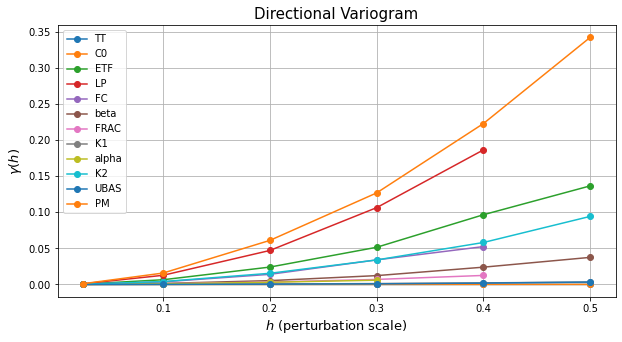

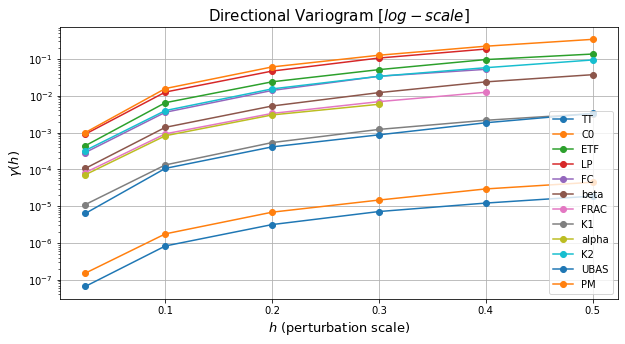

In [15]:
plotting_scale = 0.5 # any number between delta_h and one.

matrix_y = variograms.loc[variograms.index <= plotting_scale].to_numpy()
column_x = variograms.loc[variograms.index <= plotting_scale].index.to_numpy()
matrix_x = np.tile(column_x, (matrix_y.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y, marker='o')
plt.gca().set_title (r'Directional Variogram', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().legend (cols, loc='upper left', fontsize = 10)
plt.gca().grid()

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y, marker='o')
plt.gca().set_title (r'Directional Variogram $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().legend (cols, loc='lower right', fontsize = 10)
plt.gca().grid()

### Additional information for advanced users

The information below are also available to the user, if there is interest in further exploring what is happening under the hood.

**The fictive correlation matrix**

The fictive correlation matrix is a transformation of the original correlation matrix to a normal standard space.

In [16]:
fictive_matrix = experiment_3.cov_mat
cols = experiment_3.parameters.keys()
pd.DataFrame(data = fictive_matrix, index = cols, columns = cols).round(decimals=2)

,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
TT,1.00,0.69,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01
C0,0.69,1.00,0.00,0.01,0.01,0.01,0.02,0.02,0.04,0.13,0.01,0.03
ETF,0.00,0.00,1.00,0.12,-0.18,0.13,0.00,0.00,0.00,-0.22,0.00,0.00
LP,0.00,0.01,0.12,1.00,0.54,0.73,-0.14,0.00,0.01,0.00,0.00,0.00
FC,0.00,0.01,-0.18,0.54,1.00,0.35,0.20,0.12,0.01,0.38,0.00,0.00
beta,0.00,0.01,0.13,0.73,0.35,1.00,-0.11,0.00,0.01,-0.13,0.00,0.00
FRAC,0.01,0.02,0.00,-0.14,0.20,-0.11,1.00,0.00,-0.68,-0.39,-0.19,0.01
K1,0.01,0.02,0.00,0.00,0.12,0.00,0.00,1.00,-0.34,0.00,0.00,0.01
alpha,0.01,0.04,0.00,0.01,0.01,0.01,-0.68,-0.34,1.00,0.41,0.41,0.01
K2,0.00,0.13,-0.22,0.00,0.38,-0.13,-0.39,0.00,0.41,1.00,0.14,0.00


**Cross sections of sample points in the model parameter space**

Choose any pair of parameters and see the projection of all star centers and star points onto their two-dimensional space.

<AxesSubplot:title={'center':'Star Points'}, xlabel='LP', ylabel='beta'>

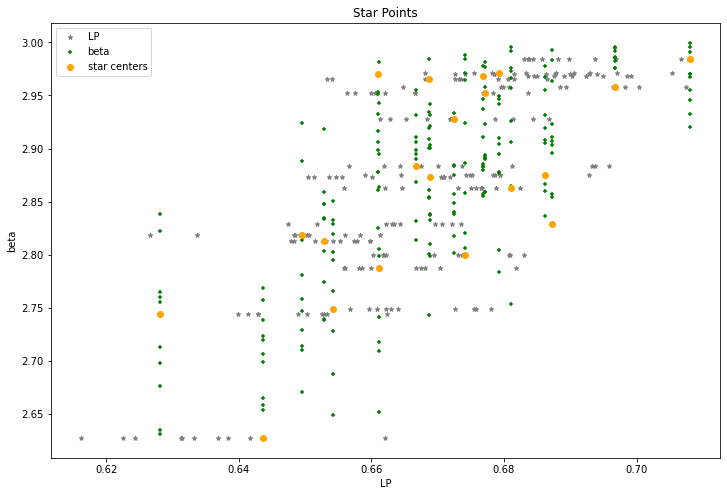

In [17]:
names = ['LP', 'beta']
experiment_3.correlation_plot(param_names=names)

**Star centers used in the GVARS experiment**

The following dataframe includes all the star centers generated.

In [18]:
cols = experiment_3.parameters.keys()
pd.DataFrame(data=experiment_3.star_centres, columns=cols)

,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
0,0.976125,0.783047,0.125819,0.686250,232.734810,2.874861,0.639481,0.051044,1.599784,0.021210,1.035858,0.995565
1,0.966637,0.784360,0.118052,0.654272,237.001920,2.749418,0.629482,0.053349,1.596257,0.023799,1.125255,1.019510
2,0.948085,0.782770,0.123899,0.660967,221.121822,2.970023,0.615163,0.050686,1.603658,0.021533,1.033804,1.005987
3,0.968753,0.786837,0.127800,0.666682,226.759816,2.883258,0.628246,0.052064,1.597755,0.021106,1.006110,0.983403
4,0.961785,0.782599,0.129221,0.677195,225.513975,2.952661,0.609101,0.050588,1.630529,0.022821,1.078288,0.997739
5,0.947294,0.779039,0.112934,0.681041,229.770960,2.862777,0.632429,0.050163,1.603346,0.021483,1.069715,1.002223
6,0.955649,0.778289,0.134678,0.708005,238.675998,2.984002,0.628204,0.052373,1.599594,0.022672,1.051267,0.989001
7,0.957185,0.782583,0.119493,0.649608,215.396407,2.818687,0.619559,0.051130,1.602780,0.022382,1.112082,0.985181
8,0.975055,0.781938,0.130634,0.643663,225.696710,2.627513,0.647548,0.051590,1.594503,0.021604,1.053604,1.013840
9,0.942106,0.778465,0.136762,0.676884,226.698277,2.968254,0.630673,0.050407,1.596238,0.021471,1.059141,1.011907


**Star points generated in the GVARS experiment along with respective model responses**

The following dataframe includes all the star points generated. For each row, the first column indicates the associated star center, the second column indicates the parameter along which the cross-sectional samples were taken, and the third column indicates the star point numbers along that cross section. The last column indicates the evaluated model response for the parameter set in each row.

In [19]:
cols = experiment_3.parameters.keys()
star_points = experiment_3.model_df.copy()
cols = list(cols)
cols.append(star_points.columns[-1])
star_points.columns = cols
star_points
# experiment_3.star_points  # this dataframe only includes star points

TT        C0       ETF        LP          FC  \
centre param points                                                       
0      TT    0       0.952887  0.783047  0.125819  0.686250  232.734810   
             1       0.971817  0.783047  0.125819  0.686250  232.734810   
             2       0.963557  0.783047  0.125819  0.686250  232.734810   
             3       0.968860  0.783047  0.125819  0.686250  232.734810   
             4       0.950994  0.783047  0.125819  0.686250  232.734810   
...                       ...       ...       ...       ...         ...   
19     PM    5       0.940966  0.780112  0.124063  0.696759  232.681429   
             6       0.940966  0.780112  0.124063  0.696759  232.681429   
             7       0.940966  0.780112  0.124063  0.696759  232.681429   
             8       0.940966  0.780112  0.124063  0.696759  232.681429   
             9       0.940966  0.780112  0.124063  0.696759  232.681429   

                         beta      FRAC        K1     alpha        K2  \
centre param points                                                     
0      TT    0       2.874861  0.639481  0.051044  1.599784  0.021210   
             1       2.874861  0.639481  0.051044  1.599784  0.021210   
             2       2.874861  0.639481  0.051044  1.599784  0.021210   
             3       2.874861  0.639481  0.051044  1.599784  0.021210   
             4       2.874861  0.639481  0.051044  1.599784  0.021210   
...                       ...       ...       ...       ...       ...   
19     PM    5       2.957867  0.606733  0.053352  1.618112  0.022359   
             6       2.957867  0.606733  0.053352  1.618112  0.022359   
             7       2.957867  0.606733  0.053352  1.618112  0.022359   
             8       2.957867  0.606733  0.053352  1.618112  0.022359   
             9       2.957867  0.606733  0.053352  1.618112  0.022359   

                         UBAS        PM  custom_HBV_SASK_3  
centre param points                                         
0      TT    0       1.035858  0.995565          18.730064  
             1       1.035858  0.995565          18.736029  
             2       1.035858  0.995565          18.733423  
             3       1.035858  0.995565          18.735092  
             4       1.035858  0.995565          18.729467  
...                       ...       ...                ...  
19     PM    5       1.143972  0.989380          18.413550  
             6       1.143972  1.014003          19.431324  
             7       1.143972  1.005906          19.095675  
             8       1.143972  1.004885          19.053386  
             9       1.143972  1.000871          18.887337  

[2400 rows x 13 columns]

**Pairs generated in the GVARS experiment using all the star points**

Each row represents the information for a pair of sample points. For each pair, the first column indicates the associated star center, the second column indicates the parameter along which the points in the pair are aligned, the third column  indicates the representative bin size (in terms of h) used in the estimation of directional variograms, the fourth column indicates the actual h value for that pair (used in binning), the fifth column indicates the star point numbers forming that pair, the sixth and seventh columns are the model responses for the two star points in the pair, and the last column (dissimilarity) is the squared difference between the two model responses in a pair.

In [20]:
experiment_3.pair_df

0          1  dissimilarity
centre param h     actual h pair_ind                                     
0      TT    0.025 0.017636 (5, 9)    18.736348  18.736576   2.599546e-08
                   0.024694 (1, 5)    18.736029  18.736348   5.097038e-08
                   0.047336 (0, 4)    18.730064  18.729467   1.778468e-07
                   0.042330 (1, 9)    18.736029  18.736576   1.497669e-07
             0.100 0.095048 (2, 6)    18.733423  18.732227   7.160111e-07
...                                         ...        ...            ...
19     PM    0.400 0.360780 (1, 3)    19.281473  18.684611   1.781221e-01
             0.500 0.526751 (4, 5)    19.283948  18.413550   3.787960e-01
                   0.451092 (3, 6)    18.684611  19.431324   2.787902e-01
                   0.525259 (1, 5)    19.281473  18.413550   3.766450e-01
             0.600 0.615571 (5, 6)    18.413550  19.431324   5.179317e-01

[10800 rows x 3 columns]

All done!